# Image Classification with Neural Network

In [2]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [33]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [4]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [5]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


## Dataset & Data loaders

In [36]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())


In [37]:
# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)


Label: 4


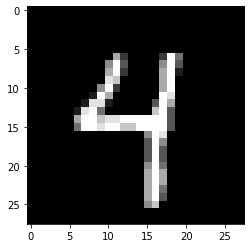

In [38]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Exploring the dataset

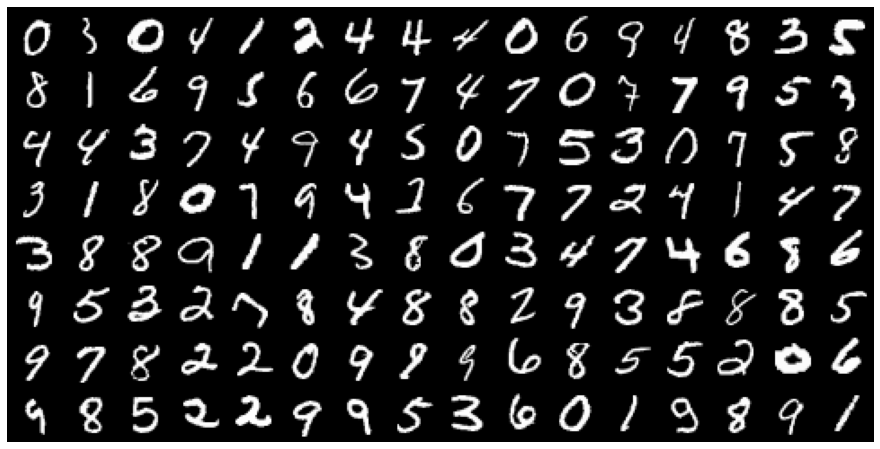

In [39]:
for imgs, preds in train_loader:
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(imgs, nrow=16).permute((1,2,0)))
  break

## Setup to move data to GPU if available

In [40]:
torch.cuda.is_available()

True

In [41]:
def get_default_device():
  if(torch.cuda.is_available):
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [44]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [55]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)


In [56]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb.device:', yb.device)
    break

xb.device: cuda:0
yb.device: cuda:0


## Model

In [46]:
hidden_layer_size = 64

In [93]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.linear3 = nn.Linear(hidden_layer_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], 100*result['val_acc']))
    


In [94]:
model = MnistModel()
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

## Training

In [48]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [51]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [95]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.13632813096046448, 'val_loss': 2.311185598373413}]

In [96]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4696, val_acc: 86.5723
Epoch [1], val_loss: 0.3349, val_acc: 90.7812
Epoch [2], val_loss: 0.2847, val_acc: 91.8164
Epoch [3], val_loss: 0.2566, val_acc: 92.6074
Epoch [4], val_loss: 0.2452, val_acc: 92.8125


In [97]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2181, val_acc: 93.7598
Epoch [1], val_loss: 0.2134, val_acc: 93.7988
Epoch [2], val_loss: 0.2090, val_acc: 93.9453
Epoch [3], val_loss: 0.2060, val_acc: 93.9160
Epoch [4], val_loss: 0.2021, val_acc: 94.0918


In [98]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1923, val_acc: 94.4043
Epoch [1], val_loss: 0.1749, val_acc: 94.6387
Epoch [2], val_loss: 0.1547, val_acc: 95.3223
Epoch [3], val_loss: 0.1346, val_acc: 95.9375
Epoch [4], val_loss: 0.1233, val_acc: 96.3867


In [99]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1162, val_acc: 96.6113
Epoch [1], val_loss: 0.1090, val_acc: 96.7578
Epoch [2], val_loss: 0.1053, val_acc: 97.0020
Epoch [3], val_loss: 0.1041, val_acc: 97.0312
Epoch [4], val_loss: 0.1098, val_acc: 96.8164


In [100]:
history += fit(2, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0980, val_acc: 97.2266
Epoch [1], val_loss: 0.1021, val_acc: 96.9824


In [101]:
history += fit(1, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0939, val_acc: 97.3828


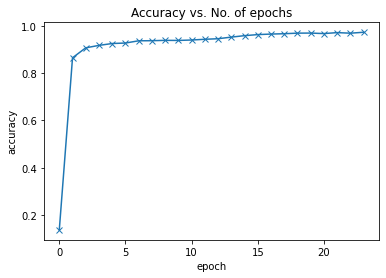

In [102]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Text(0.5, 1.0, 'Loss vs no. of epochs')

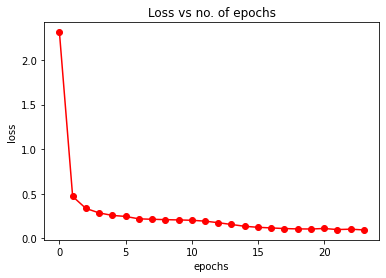

In [113]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, 'r-o')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs no. of epochs')

In [105]:
# Evaluate on test dataset
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9736328125, 'val_loss': 0.08471284061670303}

In [106]:
jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Metrics logged.


## Prediction

In [107]:
def predict_image(img, model, device):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted: 1


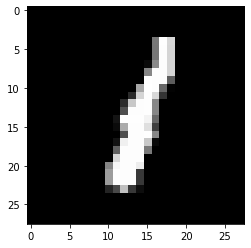

In [110]:
img, label = test_ds[89]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model,device))

## Save and upload

In [111]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [114]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/shehroze-1122/mnist-logistic-minimal


'https://jovian.ai/shehroze-1122/mnist-logistic-minimal'